# Evaluation of the Final Models

This Jupyter Notebook was inspired by different other Notebooks, as mentioned later below. It evaluates the final BA model using dataset downloaded from epitopepredict package or from blind dataset from MHCFlurry comparison table. The testing data was found out that the training has included it, hence the results aren't meaningful but well the concept will be the same if a new dataset is found for testing.
As for the final EL model, it has been evaluated on the Anthem dataset, which includes unseen peptides for trained alleles, as well as unseen alleles to test the pan method efficiency. More details are included in the paper.

Only alleles of interest, when available, were considered for testing:

HLA-A*26:01

HLA-A*32:01

HLA-A*74:01

HLA-B*48:01

In [123]:
import os, sys, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 130)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5)
from IPython.display import display, HTML, Image
from importlib import reload
import sklearn, collections, scipy, time
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, confusion_matrix
from collections import Counter

In [12]:
# alleles of interest
alleles = ["HLA-A2601",
           "HLA-A3201",
           "HLA-A7401",
           "HLA-B4801"]

# load BLIND dataset
blind = pd.read_csv("./test_data/combined_test_BLIND_dataset_from_kim2013.csv")

# define the scaling function
def scale_binding_affinity(ic50):
    log50k = np.log10(50000)
    return 1 - (np.log10(ic50) / log50k)

# list comprehension to scale binding affinity columns
binding_affinity_columns = ["meas", "netmhc", "netmhcpan", "smmpmbec_cpp"]
scaled_values = {
    f"{col}_scaled": [scale_binding_affinity(ic50) for ic50 in blind[col]] 
    for col in binding_affinity_columns
}

# Add scaled columns to the DataFrame
blind = blind.assign(**scaled_values)


In [13]:
blind.head()

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,meas_scaled,netmhc_scaled,netmhcpan_scaled,smmpmbec_cpp_scaled
0,H-2-DB,AAACNVATA,9,657.657837,154.881662,711.213514,438.530698,0.400294,0.533940,0.393058,0.437749
1,H-2-DB,AAFEFVYV,8,30831.879502,6456.542290,785.235635,10351.421667,0.044684,0.189184,0.383908,0.145557
2,H-2-DB,AAFVNDYSL,9,77.446180,17.458222,7.516229,28.054336,0.597997,0.735687,0.813576,0.691847
3,H-2-DB,AAIANQAAV,9,1.999862,9.638290,9.749896,25.703958,0.935943,0.790592,0.789528,0.699934
4,H-2-DB,AAIANQAVV,9,1.517050,8.550667,8.336812,28.773984,0.961481,0.801659,0.804000,0.689506


In [20]:
A2601 = blind.loc[blind.allele=="HLA-A2601",]
A2601.to_csv("A2601.csv", index=False)
A2601.length.value_counts()


length
9     1132
10     201
Name: count, dtype: int64

In [21]:
A3201 = blind.loc[blind.allele=="HLA-A3201",]
A3201.to_csv("A3201.csv", index=False)
A3201.length.value_counts()

length
9     256
10    193
Name: count, dtype: int64

#### Load EL testing set

In [23]:
anthem = pd.read_csv("./test_data_EL/anthem_test_data.txt", sep="\t")
anthem.head()

,HLA,peptide,Label,Length
0,HLA-A*01:01,LFGRDLSY,1,8
1,HLA-A*01:01,TDKKTHLY,1,8
2,HLA-A*01:01,RSDTPLIY,1,8
3,HLA-A*01:01,NSDLVQKY,1,8
4,HLA-A*01:01,LSDLLDWK,1,8


In [26]:
# extract alleles of interest and save separate dfs
A3201 = anthem.loc[anthem.HLA=="HLA-A*32:01",]
A3201.to_csv("A3201.csv", index=False)
print(A3201.Length.value_counts())


A2601 = anthem.loc[anthem.HLA=="HLA-A*26:01",]
A2601.to_csv("A2601.csv", index=False)
print(A2601.Length.value_counts())


B4801 = anthem.loc[anthem.HLA=="HLA-B*48:01",]
B4801.to_csv("B4801.csv", index=False)
print(B4801.Length.value_counts())

# not available
A7401 = anthem.loc[anthem.HLA=="HLA-A*74:01",]
A7401.to_csv("A7401.csv", index=False)
print(A7401.Length.value_counts())

Length
9     1373
10     231
11     101
Name: count, dtype: int64
Length
9     779
10    131
Name: count, dtype: int64
Length
9    49
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


In [44]:
import os
import numpy as np
from data_import import filter_dataset
from balance_el import preprocess_peptide_data
from blosum_func import fast_combined_blosum_encoding
from train_model_el import balanced_5_fold_cv_tf

# Define the file paths
pep_file_path = "./NetMHCpan-4.1_train_data/netcpan4.1_train.tsv" 
allele_file_path = "./NetMHCpan-4.1_train_data/training_allele_seq.pseudo"

# Specify the source type 
source_type = 'el'

# Filter dataset for the 'el' source type
filtered_data = filter_dataset(pep_file_path, source_type, allele_file_path)

# Perform Upsampling
filtered_data = preprocess_peptide_data(filtered_data)


In [46]:
sum(filtered_data.allele=="HLA-B48:01")

0

In [47]:
sum(filtered_data.allele=="HLA-A26:01")

3563

In [49]:
sum(filtered_data.allele=="HLA-A74:01")

0

In [50]:
sum(filtered_data.allele=="HLA-A32:01")

15041

## BA Evaluation

#### MHCflurry
https://github.com/hammerlab/mhcflurry-icml-compbio-2016/blob/master/notebooks/validation%20results%20analysis.ipynb

In [55]:
# concatenate all similar BA preds together
A2601 = pd.read_csv("./pred_BA/A2601_pred.csv")
A3201 = pd.read_csv("./pred_BA/A3201_pred.csv")

BA_pred = pd.concat([A2601, A3201], ignore_index=True)

# list of columns to keep
columns_to_keep = ['allele', 'peptide', 'length', 'meas_scaled', 'netmhc_scaled', 
                   'netmhcpan_scaled', 'smmpmbec_cpp_scaled', 'my_pred']

BA_pred = BA_pred[columns_to_keep]

# rename columns
BA_pred.columns = BA_pred.columns.str.replace('_scaled', '', regex=False)

BA_pred.head(10)

,allele,peptide,length,meas,netmhc,netmhcpan,smmpmbec_cpp,my_pred
0,HLA-A2601,AAAQGQAPL,9,0.084693,0.082565,0.070647,0.034044,0.125261
1,HLA-A2601,AADSFATSY,9,0.084693,0.063412,0.064050,0.006165,0.502030
2,HLA-A2601,AAILKQHKL,9,0.084693,0.057240,0.036172,-0.032141,0.090000
3,HLA-A2601,AARHKHQVM,9,0.084693,0.060007,0.042343,-0.008732,0.120320
4,HLA-A2601,AEALLADGL,9,0.084693,0.045748,0.011911,-0.169618,0.123559
5,HLA-A2601,AEFKYIAAV,9,-0.041079,0.065114,0.044684,0.035108,0.090235
6,HLA-A2601,AEGVVAFLI,9,0.084693,0.040854,0.004888,-0.253253,0.086227
7,HLA-A2601,AEIESATLF,9,0.084693,0.105336,0.065327,0.161731,0.132726
8,HLA-A2601,AEMRAYHGF,9,0.084693,0.085331,0.044046,0.049579,0.078779
9,HLA-A2601,AEMVAKYDL,9,0.084693,0.039151,0.005101,-0.341571,0.077983


In [75]:
def make_scores(ba_y, y_pred, sample_weight=None, threshold_ba=0.426):     
    
    try:
        auc = sklearn.metrics.roc_auc_score(ba_y <= threshold_ba, y_pred <= threshold_ba, sample_weight=sample_weight)
    except ValueError:
        auc = numpy.nan
    try:
        f1 = sklearn.metrics.f1_score(ba_y <= threshold_ba, y_pred <= threshold_ba, sample_weight=sample_weight)
    except ValueError:
        f1 = numpy.nan
    try:
        tau = scipy.stats.kendalltau(y_pred, ba_y)[0]
    except ValueError:
        tau = numpy.nan
    try:
        pc, p_value = pearsonr(ba_y, y_pred)
    except ValueError:
        auc = numpy.nan
    
    return dict(
        auc=auc,
        f1=f1,
        tau=tau,
        pc=pc
    ) 

def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

In [76]:
scores_df = collections.defaultdict(list)
predictors = BA_pred.columns[4:]
pairs = [
    ("overall", BA_pred)
] + list(BA_pred.groupby("allele"))

for (allele, grouped) in pairs:
    scores_df["allele"].append(allele)
    scores_df["test_size"].append(len(grouped.meas))
    for predictor in predictors:
        scores = make_scores(grouped.meas, grouped[predictor])
        for (key, value) in scores.items():
            scores_df["%s_%s" % (predictor, key)].append(value)
            
scores_df = pandas.DataFrame(scores_df)

scores_df.index = scores_df.allele
scores_df

,allele,test_size,netmhc_auc,netmhc_f1,netmhc_tau,netmhc_pc,netmhcpan_auc,netmhcpan_f1,netmhcpan_tau,netmhcpan_pc,smmpmbec_cpp_auc,smmpmbec_cpp_f1,smmpmbec_cpp_tau,smmpmbec_cpp_pc,my_pred_auc,my_pred_f1,my_pred_tau,my_pred_pc
allele,,,,,,,,,,,,,,,,,,
overall,overall,1782,0.815729,0.938952,0.422942,0.750520,0.828765,0.949342,0.436425,0.785845,0.814924,0.901565,0.413489,0.597323,0.932882,0.977220,0.561895,0.879705
HLA-A2601,HLA-A2601,1333,0.742109,0.951472,0.436646,0.751937,0.791067,0.962748,0.451666,0.789063,0.781818,0.956739,0.422900,0.577492,0.936594,0.984564,0.497056,0.879271
HLA-A3201,HLA-A3201,449,0.856498,0.888889,0.448284,0.711823,0.841015,0.897436,0.480669,0.751433,0.702842,0.619958,0.493693,0.613146,0.918263,0.949367,0.652495,0.866021


In [77]:
# extract the "overall" row
overall_row = scores_df.loc["overall"]

# create dictionaries for each group based on suffixes, and sort by values
auc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_auc')}
f1_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_f1')}
tau_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_tau')}
pc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_pc')}

# sort each group by value in descending order
sorted_auc_values = dict(sorted(auc_values.items(), key=lambda item: item[1], reverse=True))
sorted_f1_values = dict(sorted(f1_values.items(), key=lambda item: item[1], reverse=True))
sorted_tau_values = dict(sorted(tau_values.items(), key=lambda item: item[1], reverse=True))
sorted_pc_values = dict(sorted(pc_values.items(), key=lambda item: item[1], reverse=True))

# combine the sorted dictionaries in the desired order
sorted_overall = {**sorted_auc_values, **sorted_pc_values, **sorted_f1_values, **sorted_tau_values}

# convert to a pandas Series to print nicely
sorted_overall_series = pd.Series(sorted_overall)

# print the sorted Series
print(sorted_overall_series)


my_pred_auc         0.932882
netmhcpan_auc       0.828765
netmhc_auc          0.815729
smmpmbec_cpp_auc    0.814924
my_pred_pc          0.879705
netmhcpan_pc        0.785845
netmhc_pc           0.750520
smmpmbec_cpp_pc     0.597323
my_pred_f1          0.977220
netmhcpan_f1        0.949342
netmhc_f1           0.938952
smmpmbec_cpp_f1     0.901565
my_pred_tau         0.561895
netmhcpan_tau       0.436425
netmhc_tau          0.422942
smmpmbec_cpp_tau    0.413489
dtype: float64


In [78]:
# extract the "HLA-A2601" row
overall_row = scores_df.loc["HLA-A2601"]

# create dictionaries for each group based on suffixes, and sort by values
auc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_auc')}
f1_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_f1')}
tau_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_tau')}
pc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_pc')}

# sort each group by value in descending order
sorted_auc_values = dict(sorted(auc_values.items(), key=lambda item: item[1], reverse=True))
sorted_f1_values = dict(sorted(f1_values.items(), key=lambda item: item[1], reverse=True))
sorted_tau_values = dict(sorted(tau_values.items(), key=lambda item: item[1], reverse=True))
sorted_pc_values = dict(sorted(pc_values.items(), key=lambda item: item[1], reverse=True))

# combine the sorted dictionaries in the desired order
sorted_overall = {**sorted_auc_values, **sorted_pc_values, **sorted_f1_values, **sorted_tau_values}

# convert to a pandas Series to print nicely
sorted_overall_series = pd.Series(sorted_overall)

# print the sorted Series
print(sorted_overall_series)

my_pred_auc         0.936594
netmhcpan_auc       0.791067
smmpmbec_cpp_auc    0.781818
netmhc_auc          0.742109
my_pred_pc          0.879271
netmhcpan_pc        0.789063
netmhc_pc           0.751937
smmpmbec_cpp_pc     0.577492
my_pred_f1          0.984564
netmhcpan_f1        0.962748
smmpmbec_cpp_f1     0.956739
netmhc_f1           0.951472
my_pred_tau         0.497056
netmhcpan_tau       0.451666
netmhc_tau          0.436646
smmpmbec_cpp_tau    0.422900
dtype: float64


In [79]:
# extract the "HLA-A3201" row
overall_row = scores_df.loc["HLA-A3201"]

# create dictionaries for each group based on suffixes, and sort by values
auc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_auc')}
f1_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_f1')}
tau_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_tau')}
pc_values = {key: overall_row[key] for key in overall_row.index if key.endswith('_pc')}

# sort each group by value in descending order
sorted_auc_values = dict(sorted(auc_values.items(), key=lambda item: item[1], reverse=True))
sorted_f1_values = dict(sorted(f1_values.items(), key=lambda item: item[1], reverse=True))
sorted_tau_values = dict(sorted(tau_values.items(), key=lambda item: item[1], reverse=True))
sorted_pc_values = dict(sorted(pc_values.items(), key=lambda item: item[1], reverse=True))

# combine the sorted dictionaries in the desired order
sorted_overall = {**sorted_auc_values, **sorted_pc_values, **sorted_f1_values, **sorted_tau_values}

# convert to a pandas Series to print nicely
sorted_overall_series = pd.Series(sorted_overall)

# print the sorted Series
print(sorted_overall_series)

my_pred_auc         0.918263
netmhc_auc          0.856498
netmhcpan_auc       0.841015
smmpmbec_cpp_auc    0.702842
my_pred_pc          0.866021
netmhcpan_pc        0.751433
netmhc_pc           0.711823
smmpmbec_cpp_pc     0.613146
my_pred_f1          0.949367
netmhcpan_f1        0.897436
netmhc_f1           0.888889
smmpmbec_cpp_f1     0.619958
my_pred_tau         0.652495
smmpmbec_cpp_tau    0.493693
netmhcpan_tau       0.480669
netmhc_tau          0.448284
dtype: float64


In [80]:
# concatenate all similar BA preds together
A7401 = pd.read_csv("./pred_BA/A7401_pred.csv")
B4801 = pd.read_csv("./pred_BA/B4801_pred.csv")

BA_pred_2 = pd.concat([A7401, B4801], ignore_index=True)

# list of columns to keep
columns_to_keep_2 = ['allele', 'peptide' ,'log50k' ,'my_pred']

BA_pred_2 = BA_pred_2[columns_to_keep_2]

BA_pred_2.head(10)

,allele,peptide,log50k,my_pred
0,HLA-A*74:01,KVVPRRKAK,0.42,0.829938
1,HLA-A*74:01,AFDLSFFLK,0.08,0.036982
2,HLA-A*74:01,QVPLRPMTY,0.08,0.068431
3,HLA-A*74:01,PIPVGDIYK,0.08,-0.275995
4,HLA-B*48:01,RQWFLDLPL,0.95,0.978207
5,HLA-B*48:01,KQLGQVMLL,0.82,0.825010
6,HLA-B*48:01,WKYLNAVSL,0.76,0.765264
7,HLA-B*48:01,RQWAQDLTL,0.68,0.690258
8,HLA-B*48:01,REMGIVDLL,0.58,0.591276
9,HLA-B*48:01,RRDKRSVAL,0.54,0.502796


Pearson Correlation (Test Set): 0.8478763086079156
P-Value: 3.351462962695684e-77
AUC score: 0.9943609022556391


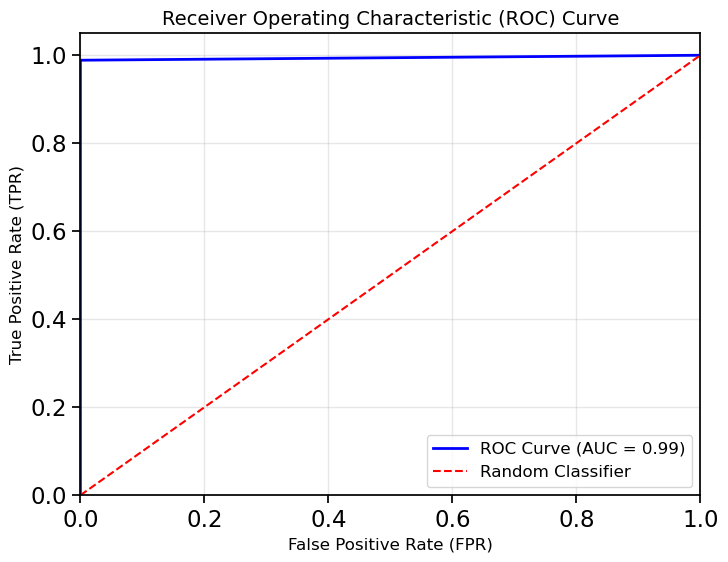

In [103]:
# Pearson Correlation on A7401
y_pred = B4801.my_pred
# ensure y_pred is a numpy array
y_pred = np.array(y_pred)
pc, p_value = pearsonr(B4801.log50k, y_pred)
print(f"Pearson Correlation (Test Set): {pc}")
print(f"P-Value: {p_value}")

# AUC
threshold = 0.426
y_true_binary = (B4801.log50k <= threshold).astype(int)
y_pred_binary = (y_pred <= threshold).astype(int)
# calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary)
# calculate the AUC
roc_auc = auc(fpr, tpr)
# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])  # ensure the X-axis spans from 0 to 1
plt.ylim([0.0, 1.05])  # ensure the Y-axis spans from 0 to slightly above 1
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
auc_num = sklearn.metrics.roc_auc_score(y_true_binary, y_pred_binary)
print(f"AUC score: {auc_num}")

### EL Evaluation
https://github.com/s7776d/CapsNet-MHC/blob/main/Metrics_Calculator.ipynb

## EL Evaluation on Unseen Peptides

#### HLA-A*26:01

In [130]:
pd.read_csv('./pred_EL/A2601_pred.csv').Length.value_counts()

Length
9     779
10    131
Name: count, dtype: int64

In [190]:
from os import readlink
f = open('./pred_EL/A2601_pred.csv',"r")
lines = f.readlines()
y_prob8, y_prob9, y_prob10, y_prob11, y_prob12 = [], [], [], [], []
y_true8, y_true9, y_true10, y_true11, y_true12 = [], [], [], [], []
lines.pop(0)
plot = []
for x in lines:
        if (x.split(',')[3]) == '8':
            y_prob8.append(x.split(',')[6])
            y_true8.append(x.split(',')[2])
        if (x.split(',')[3]) == '9':
            y_prob9.append(x.split(',')[6])
            y_true9.append(x.split(',')[2])
        if (x.split(',')[3]) == '10':
            y_prob10.append(x.split(',')[6])
            y_true10.append(x.split(',')[2])
        if (x.split(',')[3]) == '11':
            y_prob11.append(x.split(',')[6])
            y_true11.append(x.split(',')[2])
        if (x.split(',')[3]) == '12':
            y_prob12.append(x.split(',')[6])
            y_true12.append(x.split(',')[2])

        
f.close()
y_prob8 = [float(num) for num in y_prob8]
y_true8 = [float(num) for num in y_true8]
y_pred8 = [round(num) for num in y_prob8]

y_prob9 = [float(num) for num in y_prob9]
y_true9 = [float(num) for num in y_true9]
y_pred9 = [round(num) for num in y_prob9]

y_prob10 = [float(num) for num in y_prob10]
y_true10 = [float(num) for num in y_true10]
y_pred10 = [round(num) for num in y_prob10]

y_prob11 = [float(num) for num in y_prob11]
y_true11 = [float(num) for num in y_true11]
y_pred11 = [round(num) for num in y_prob11]

y_prob12 = [float(num) for num in y_prob12]
y_true12 = [float(num) for num in y_true12]
y_pred12 = [round(num) for num in y_prob12]


plot.append(len(y_true8))
plot.append(len(y_true9))
plot.append(len(y_true10))
plot.append(len(y_true11))
plot.append(len(y_true12))

### 9-mer

MCC Error:  22865427780
tn = 366, fp = 24, fn = 55, tp = 334
y_pred8: 0 = 0 | 1 = 358
y_true8: 0 = 0 | 1 = 389
auc=0.9655|sn=0.8586|sp=0.9385|acc=0.8986|mcc=nan
precision=0.9330|recall=0.8586|f1=0.8942|aupr=0.9675


<Axes: >

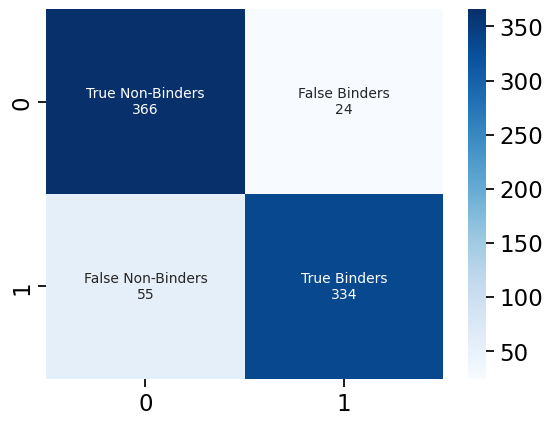

In [191]:
tn, fp, fn, tp = confusion_matrix(y_true9, y_pred9, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true9, y_prob9)
prec, reca, _ = precision_recall_curve(y_true9, y_prob9)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred8: 0 = {} | 1 = {}'.format(Counter(y_pred8)[0], Counter(y_pred9)[1]))
print('y_true8: 0 = {} | 1 = {}'.format(Counter(y_true8)[0], Counter(y_true9)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true9, y_pred9, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

### 10-mer

MCC Error:  17623320
tn = 63, fp = 3, fn = 16, tp = 49
y_pred10: 0 = 79 | 1 = 52
y_true10: 0 = 66 | 1 = 65
auc=0.9245|sn=0.7538|sp=0.9545|acc=0.8550|mcc=nan
precision=0.9423|recall=0.7538|f1=0.8376|aupr=0.9424


<Axes: >

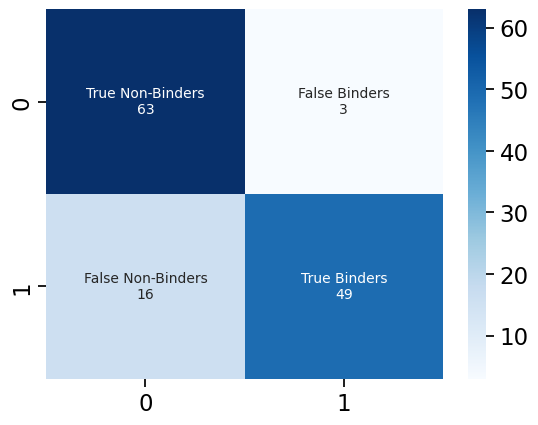

In [192]:
tn, fp, fn, tp = confusion_matrix(y_true10, y_pred10, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true10, y_prob10)
prec, reca, _ = precision_recall_curve(y_true10, y_prob10)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred10: 0 = {} | 1 = {}'.format(Counter(y_pred10)[0], Counter(y_pred10)[1]))
print('y_true10: 0 = {} | 1 = {}'.format(Counter(y_true10)[0], Counter(y_true10)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true10, y_pred10, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

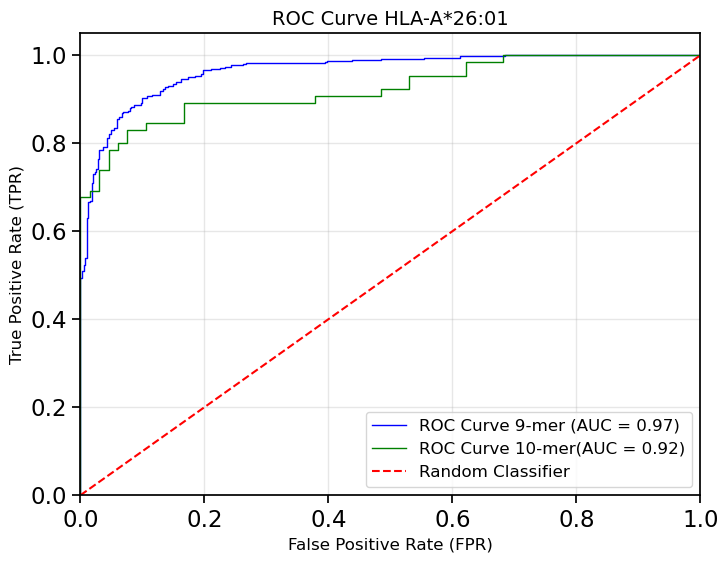

In [193]:
# AUC
# calculate the ROC curve
fpr9, tpr9, thresholds9 = roc_curve(y_true9, y_prob9)
# calculate the AUC
roc_auc9 = auc(fpr9, tpr9)

# calculate the ROC curve
fpr10, tpr10, thresholds10 = roc_curve(y_true10, y_prob10)
# calculate the AUC
roc_auc10 = auc(fpr10, tpr10)
 

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr9, tpr9, color='blue', lw=1, label=f'ROC Curve 9-mer (AUC = {roc_auc9:.2f})')

plt.xlim([0.0, 1.0])  # ensure the X-axis spans from 0 to 1
plt.ylim([0.0, 1.05])  # ensure the Y-axis spans from 0 to slightly above 1
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve HLA-A*26:01', fontsize=14)

plt.plot(fpr10, tpr10, color='green', lw=1, label=f'ROC Curve 10-mer(AUC = {roc_auc10:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)


### Generally

MCC Error:  42439920000
tn = 429, fp = 27, fn = 71, tp = 383
y_pred: 0 = 500 | 1 = 410
y_true: 0 = 456 | 1 = 454
auc=0.9605|sensitivity=0.8436|specificity=0.9408|acc=0.8923|mcc=nan
precision=0.9341|recall=0.8436|f1=0.8866|aupr=0.9644


<Axes: >

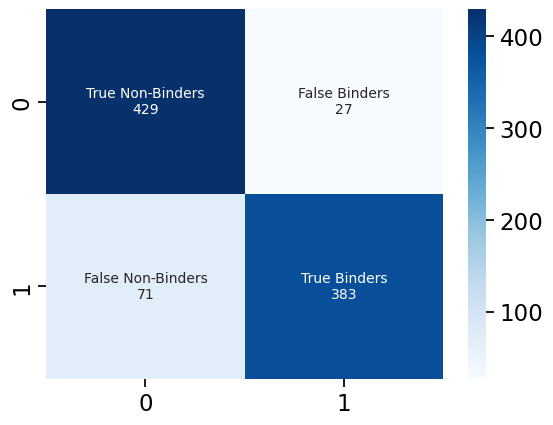

In [170]:
from os import readlink
f = open('./pred_EL/A2601_pred.csv',"r")
lines = f.readlines()
y_prob = []
y_true = []
lines.pop(0)
#lines.pop(-1)
for x in lines:
    #if (x.split('\t')[3]) == '12':
        y_prob.append(x.split(',')[6])
        y_true.append(x.split(',')[2])
f.close()
y_prob = [float(num) for num in y_prob]
y_true = [float(num) for num in y_true]
y_pred = [round(num) for num in y_prob]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true, y_prob)
prec, reca, _ = precision_recall_curve(y_true, y_prob)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred: 0 = {} | 1 = {}'.format(Counter(y_pred)[0], Counter(y_pred)[1]))
print('y_true: 0 = {} | 1 = {}'.format(Counter(y_true)[0], Counter(y_true)[1]))
print('auc={:.4f}|sensitivity={:.4f}|specificity={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true, y_pred, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

### HLA-A*32:01

In [179]:
pd.read_csv('./pred_EL/A3201_pred.csv').Length.value_counts()

Length
9     1373
10     231
11     101
Name: count, dtype: int64

In [189]:
from os import readlink
f = open('./pred_EL/A3201_pred.csv',"r")
lines = f.readlines()
y_prob9, y_prob10, y_prob11 = [], [], []
y_true9, y_true10, y_true11 = [], [], []
lines.pop(0)
plot = []
for x in lines:
        if (x.split(',')[3]) == '9':
            y_prob9.append(x.split(',')[6])
            y_true9.append(x.split(',')[2])
        if (x.split(',')[3]) == '10':
            y_prob10.append(x.split(',')[6])
            y_true10.append(x.split(',')[2])
        if (x.split(',')[3]) == '11':
            y_prob11.append(x.split(',')[6])
            y_true11.append(x.split(',')[2])

        
f.close()

y_prob9 = [float(num) for num in y_prob9]
y_true9 = [float(num) for num in y_true9]
y_pred9 = [round(num) for num in y_prob9]

y_prob10 = [float(num) for num in y_prob10]
y_true10 = [float(num) for num in y_true10]
y_pred10 = [round(num) for num in y_prob10]

y_prob11 = [float(num) for num in y_prob11]
y_true11 = [float(num) for num in y_true11]
y_pred11 = [round(num) for num in y_prob11]



plot.append(len(y_true9))
plot.append(len(y_true10))
plot.append(len(y_true11))

### 9-mer

MCC Error:  207258512832
tn = 659, fp = 28, fn = 205, tp = 481
y_pred9: 0 = 864 | 1 = 509
y_true9: 0 = 687 | 1 = 686
auc=0.9648|sn=0.7012|sp=0.9592|acc=0.8303|mcc=nan
precision=0.9450|recall=0.7012|f1=0.8050|aupr=0.9599


<Axes: >

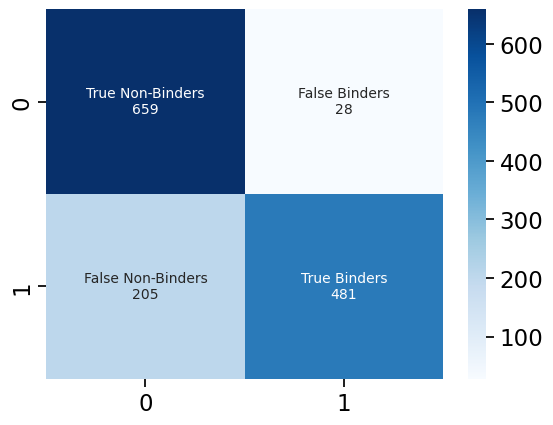

In [181]:
tn, fp, fn, tp = confusion_matrix(y_true9, y_pred9, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true9, y_prob9)
prec, reca, _ = precision_recall_curve(y_true9, y_prob9)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred9: 0 = {} | 1 = {}'.format(Counter(y_pred9)[0], Counter(y_pred9)[1]))
print('y_true9: 0 = {} | 1 = {}'.format(Counter(y_true9)[0], Counter(y_true9)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true9, y_pred9, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

### 10-mer

MCC Error:  141190560
tn = 114, fp = 2, fn = 54, tp = 61
y_pred10: 0 = 168 | 1 = 63
y_true10: 0 = 116 | 1 = 115
auc=0.9211|sn=0.5304|sp=0.9828|acc=0.7576|mcc=nan
precision=0.9683|recall=0.5304|f1=0.6854|aupr=0.9326


<Axes: >

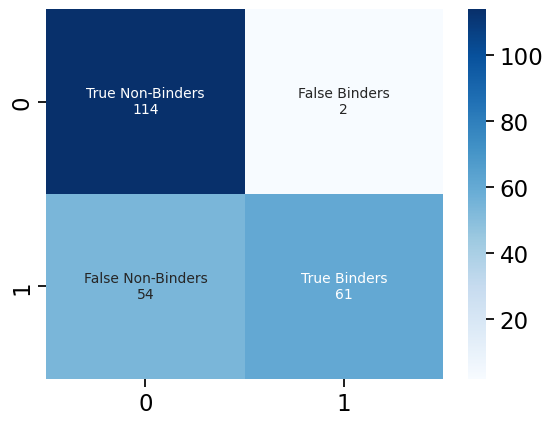

In [182]:
tn, fp, fn, tp = confusion_matrix(y_true10, y_pred10, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true10, y_prob10)
prec, reca, _ = precision_recall_curve(y_true10, y_prob10)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred10: 0 = {} | 1 = {}'.format(Counter(y_pred10)[0], Counter(y_pred10)[1]))
print('y_true10: 0 = {} | 1 = {}'.format(Counter(y_true10)[0], Counter(y_true10)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))


cf_matrix = confusion_matrix(y_true10, y_pred10, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

### 11-mer

MCC Error:  4431900
tn = 51, fp = 0, fn = 28, tp = 22
y_pred11: 0 = 79 | 1 = 22
y_true11: 0 = 51 | 1 = 50
auc=0.9584|sn=0.4400|sp=1.0000|acc=0.7228|mcc=nan
precision=1.0000|recall=0.4400|f1=0.6111|aupr=0.9608


<Axes: >

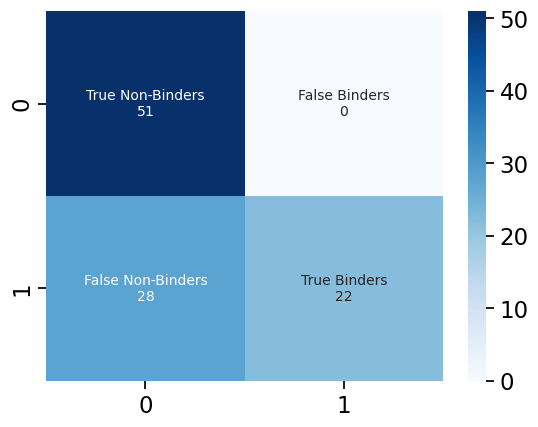

In [183]:
tn, fp, fn, tp = confusion_matrix(y_true11, y_pred11, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true11, y_prob11)
prec, reca, _ = precision_recall_curve(y_true11, y_prob11)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred11: 0 = {} | 1 = {}'.format(Counter(y_pred11)[0], Counter(y_pred11)[1]))
print('y_true11: 0 = {} | 1 = {}'.format(Counter(y_true11)[0], Counter(y_true11)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true11, y_pred11, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

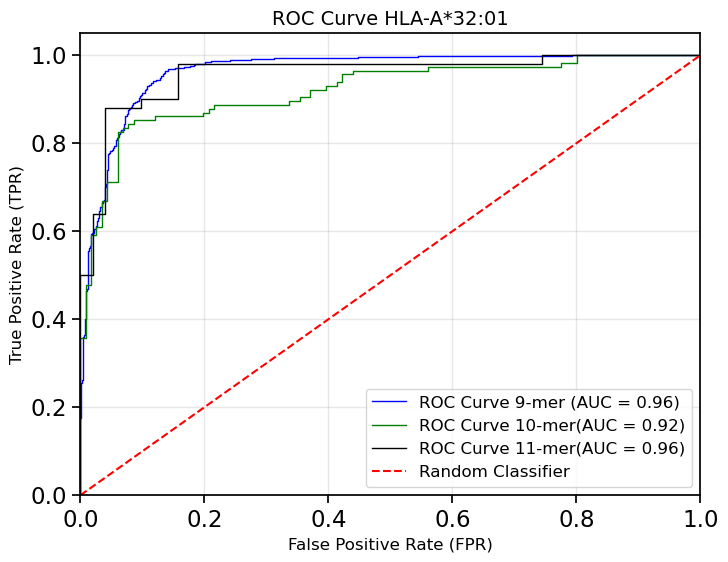

In [188]:
# AUC
# calculate the ROC curve
fpr9, tpr9, thresholds9 = roc_curve(y_true9, y_prob9)
# calculate the AUC
roc_auc9 = auc(fpr9, tpr9)

# calculate the ROC curve
fpr10, tpr10, thresholds10 = roc_curve(y_true10, y_prob10)
# calculate the AUC
roc_auc10 = auc(fpr10, tpr10)

# calculate the ROC curve
fpr11, tpr11, thresholds11 = roc_curve(y_true11, y_prob11)
# calculate the AUC
roc_auc11 = roc_auc_score(y_true11, y_prob11) 

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr9, tpr9, color='blue', lw=1, label=f'ROC Curve 9-mer (AUC = {roc_auc9:.2f})')

plt.xlim([0.0, 1.0])  # ensure the X-axis spans from 0 to 1
plt.ylim([0.0, 1.05])  # ensure the Y-axis spans from 0 to slightly above 1
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve HLA-A*32:01', fontsize=14)

plt.plot(fpr10, tpr10, color='green', lw=1, label=f'ROC Curve 10-mer(AUC = {roc_auc10:.2f})')

plt.plot(fpr11, tpr11, color='black', lw=1, label=f'ROC Curve 11-mer(AUC = {roc_auc11:.2f})')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)


### Generally

MCC Error:  479609674236
tn = 824, fp = 30, fn = 287, tp = 564
y_pred: 0 = 1111 | 1 = 594
y_true: 0 = 854 | 1 = 851
auc=0.9591|sensitivity=0.6627|specificity=0.9649|acc=0.8141|mcc=nan
precision=0.9495|recall=0.6627|f1=0.7806|aupr=0.9555


<Axes: >

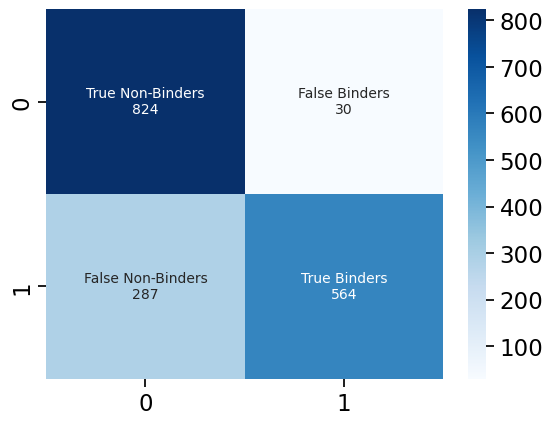

In [158]:
from os import readlink
f = open('./pred_EL/A3201_pred.csv',"r")
lines = f.readlines()
y_prob = []
y_true = []
lines.pop(0)
#lines.pop(-1)
for x in lines:
    #if (x.split('\t')[3]) == '12':
        y_prob.append(x.split(',')[6])
        y_true.append(x.split(',')[2])
f.close()
y_prob = [float(num) for num in y_prob]
y_true = [float(num) for num in y_true]
y_pred = [round(num) for num in y_prob]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true, y_prob)
prec, reca, _ = precision_recall_curve(y_true, y_prob)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred: 0 = {} | 1 = {}'.format(Counter(y_pred)[0], Counter(y_pred)[1]))
print('y_true: 0 = {} | 1 = {}'.format(Counter(y_true)[0], Counter(y_true)[1]))
print('auc={:.4f}|sensitivity={:.4f}|specificity={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

cf_matrix = confusion_matrix(y_true, y_pred, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

## EL Evaluation on Unseen Alleles

In [143]:
pd.read_csv('./pred_EL/B4801_pred.csv').Length.value_counts()

Length
9    49
Name: count, dtype: int64

In [194]:
from os import readlink
f = open('./pred_EL/B4801_pred.csv',"r")
lines = f.readlines()
y_prob9 = []
y_true9 = []
lines.pop(0)
plot = []
for x in lines:
        if (x.split(',')[3]) == '9':
            y_prob9.append(x.split(',')[6])
            y_true9.append(x.split(',')[2])

        
f.close()

y_prob9 = [float(num) for num in y_prob9]
y_true9 = [float(num) for num in y_true9]
y_pred9 = [round(num) for num in y_prob9]


plot.append(len(y_true9))

tn, fp, fn, tp = confusion_matrix(y_true9, y_pred9, labels = [0, 1]).ravel().tolist()
accuracy = (tp+tn)/(tn+fp+fn+tp)
try:
    mcc = ((tp*tn) - (fn*fp)) / np.sqrt(np.float((tp+fn)*(tn+fp)*(tp+fp)*(tn+fn)))
except:
    print('MCC Error: ', (tp+fn)*(tn+fp)*(tp+fp)*(tn+fn))
    mcc = np.nan
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

try:
    recall = tp / (tp+fn)
except:
    recall = np.nan

try:
    precision = tp / (tp+fp)
except:
    precision = np.nan

try: 
    f1 = 2*precision*recall / (precision+recall)
except:
    f1 = np.nan

roc_auc = roc_auc_score(y_true9, y_prob9)
prec, reca, _ = precision_recall_curve(y_true9, y_prob9)
aupr = auc(reca, prec)

print('tn = {}, fp = {}, fn = {}, tp = {}'.format(tn, fp, fn, tp))
print('y_pred9: 0 = {} | 1 = {}'.format(Counter(y_pred9)[0], Counter(y_pred9)[1]))
print('y_true9: 0 = {} | 1 = {}'.format(Counter(y_true9)[0], Counter(y_true9)[1]))
print('auc={:.4f}|sn={:.4f}|sp={:.4f}|acc={:.4f}|mcc={:.4f}'.format(roc_auc, sensitivity, specificity, accuracy, mcc))
print('precision={:.4f}|recall={:.4f}|f1={:.4f}|aupr={:.4f}'.format(precision, recall, f1, aupr))

MCC Error:  154800
tn = 25, fp = 0, fn = 18, tp = 6
y_pred9: 0 = 43 | 1 = 6
y_true9: 0 = 25 | 1 = 24
auc=0.9367|sn=0.2500|sp=1.0000|acc=0.6327|mcc=nan
precision=1.0000|recall=0.2500|f1=0.4000|aupr=0.9147


<Axes: >

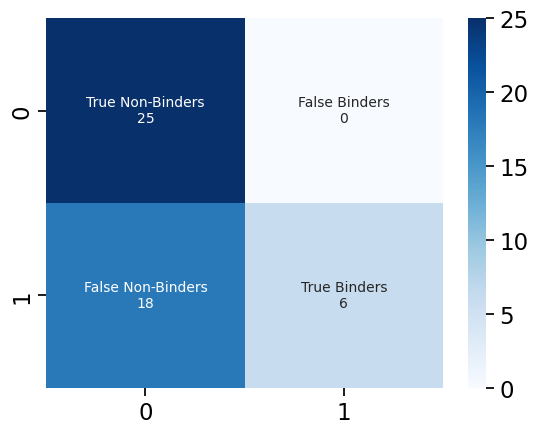

In [195]:
cf_matrix = confusion_matrix(y_true9, y_pred9, labels = [0, 1])
group_names = ['True Non-Binders','False Binders','False Non-Binders','True Binders']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 10})

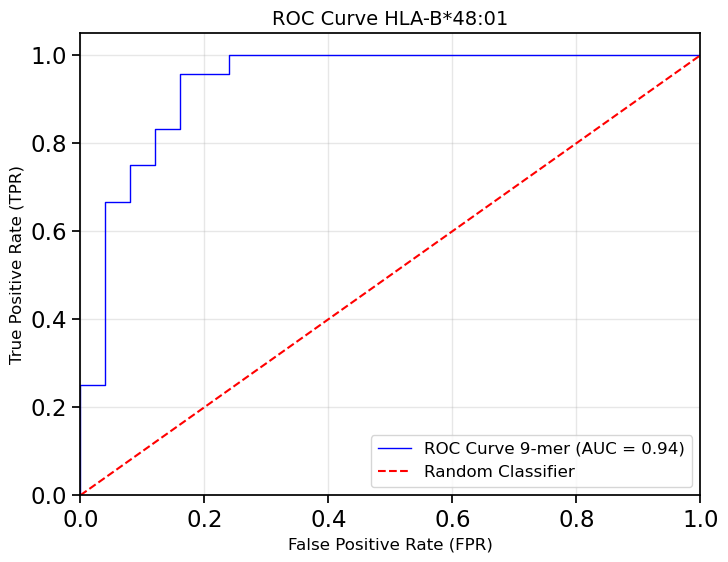

In [196]:
# AUC
# calculate the ROC curve
fpr9, tpr9, thresholds9 = roc_curve(y_true9, y_prob9)
# calculate the AUC
roc_auc9 = auc(fpr9, tpr9)


# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr9, tpr9, color='blue', lw=1, label=f'ROC Curve 9-mer (AUC = {roc_auc9:.2f})')

plt.xlim([0.0, 1.0])  # ensure the X-axis spans from 0 to 1
plt.ylim([0.0, 1.05])  # ensure the Y-axis spans from 0 to slightly above 1
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve HLA-B*48:01', fontsize=14)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)


In [ ]:
# get BA data for 1 specific allele
allele = 'HLA-B*48:01'
data = mhclearn.get_evaluation_set1(allele)



In [8]:
data.head()

,species,allele,length,peptide,inequality,ic50,log50k
23069,human,HLA-B*48:01,9,RQWFLDLPL,=,1.732478,0.95
23070,human,HLA-B*48:01,9,KQLGQVMLL,=,6.722476,0.82
23071,human,HLA-B*48:01,9,WKYLNAVSL,=,14.000000,0.76
23072,human,HLA-B*48:01,9,RQWAQDLTL,=,31.000000,0.68
23073,human,HLA-B*48:01,9,REMGIVDLL,=,93.732573,0.58


In [9]:
data.length.value_counts()

length
9    275
Name: count, dtype: int64